## Below is the exact same code as in Phase V, but the final block returns every activity's graph similar to the CT graph we saw in the Data Analysis section. Feel free to modify the parameters of return_graphs to visualize the data you want to see most.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path
import matplotlib.patches as patches
import requests
from bs4 import BeautifulSoup
import io
from csv import writer
import re
import seaborn as sns
import cartopy.crs as ccrs
import cartopy

ihsa_tidy = pd.read_csv('Working_IHSA_Deposit.csv', keep_default_na = False, na_values = '', dtype = {"YEAR":int, "LAT":float, "LONG":float})

In [2]:
def lighten_color(color, amount=0.5):
    """
    From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def draw_arrows(mydata, coloring, scale): #mydata = vals[div] for some div
    """
    Draws the arrows between the datapoints plotted by plot_points to show direction of change in location
    Inputs: mydata = vals[div] for some div
            coloring = the color of the plotted points, to be lightened by lighten_color
            scale = size of the arrows relative to the normal plotted size of 2
    Outputs: triangles on the path between the points which point in the direction of movement (i.e. time)
    """
    
    #between each pair of points
    for i in range(mydata.shape[0]-1):
        #coordinates of the first point 
        long1 = mydata.iloc[i]["Long"]
        lat1 = mydata.iloc[i]["Lat"]
        
        # coordinates of the triangle, the center between the first point and the second point
        arrow_base_long = long1 + (mydata.iloc[i+1]["Long"]-mydata.iloc[i]["Long"])/2
        arrow_base_lat = lat1 + (mydata.iloc[i+1]["Lat"]-mydata.iloc[i]["Lat"])/2
        
        #'rot' is the direction of the triangle in pyplot terms (0 'rot' is vertical up, 90 is horizontal left, and so on)
        #determined with a bit of basic geometry below
        theta = np.arctan(abs(arrow_base_lat-lat1)/abs(arrow_base_long-long1))
        if long1> arrow_base_long:
            if lat1 < arrow_base_lat:
                rot = 90-np.degrees(theta)
            else:
                rot = 90+np.degrees(theta)
        else:
            if lat1 < arrow_base_lat:
                rot = -(90-np.degrees(theta))
            else:
                rot = -(90+np.degrees(theta))
        
        #plot the triangle to appear like an arrow
        plt.plot(arrow_base_long, arrow_base_lat, marker=(3, 0, rot), markersize=scale*12, linestyle='None', color = lighten_color(coloring, 0.5))
        
def plot_points(mydatas, name, connected = False, coloring = "black", size = 50, scale = 1):
    """
    Plots any series of coordinates
    
    Inputs: mydatas = a list of dataframes, of which each dataframe has columns ["Year", "Lat", "Long"]
            connected = include the lines between points to indicate movement, otherwise just plot as if a scatterplot
            coloring = the color of all of the series
            size = size of markers
            scale = size of markers AND lines + triangles (arrows) relative to the preferred ratio between graph size and point size
    Outputs: The scatterplot of points, specified as above. Note, this does NOT plot the background map, just the points
    """
    
    #for each matrix as formatted above
    for i in range(len(mydatas)):
        mydata = mydatas[i]
        
        #plot the lines bewteen the points if necessary
        s = scale*size/25
        plt.plot("Long", "Lat", data = mydata, linestyle='--' if connected else 'None', linewidth = s*1.5, color = coloring)
        
        #draw the arrows (triangles) between points if necessary
        if connected: draw_arrows(mydata, coloring, s)
        
        #plot the points
        #if there at least 2 points, plot the first point with a diamond and the last point with an 'X'
        if mydata.shape[0] > 1:
            named, = plt.plot("Long", "Lat", data = mydata.iloc[1:-1], marker='o', markersize=s*10, linewidth = 0, color = coloring, label = name)
            plt.plot("Long", "Lat", data = mydata.iloc[0], marker='D', markersize=s*12, color = coloring)
            plt.plot("Long", "Lat", data = mydata.iloc[-1], marker='X', markersize=s*15, color = coloring)
            if i == len(mydatas)-1: return named
        elif mydata.shape[0] == 1:
            named, = plt.plot("Long", "Lat", data = mydata.iloc[0], marker='o', markersize=s*10, linewidth = 0, color = coloring, label = name)
            if i == len(mydatas)-1: return named

def return_data(ihsa_subset, weighting = "equal", window = 1, to_graph = True):
    """
    Takes a subset of ihsa_tidy and returns the weighted center of each activity-year-division
    
    Inputs: ihsa_subset = any subset of ihsa_tidy that contains all columns
            weighting = the method of weighting (see above)
            window = if a moving average is to be applied to smooth the data, how many years to apply moving average over
            to_graph = formats the returned data to be read properly by return_graphs (below)
    Outputs: metadata = a dictionary of dictionaries which contains a matrix.
                first dictionary: keys are activity abbreviations
                second dictionary: keys are divisions. If to_graph, the actual divisions, else the global divisions
                matrix: [[year, lat, long], [year, lat, long], ...]
             goods = a dictionary.
                keys: activity abbreviations 
                entries: lists of years that activity has had consistent divisions for at least window-many years 
    """
    
    #instantiate the outputs
    metadata = {}
    goods = {}
    count = 0
    
    #for each abbreviation
    for abbr in ihsa_subset["ABBR"].unique():
        this_activity = ihsa_subset[ihsa_subset["ABBR"] == abbr.upper()]
        
        #'pos_by_div' is the dictionary within the first dictionary, short for 'position_by_division'
        pos_by_div = {}
        
        #the first year we look at is the minimum year
        year = this_activity["YEAR"].min()
        goodyears = []
        
        #if there window is greater than the difference bewteen the current year and the max year, we know there isn't enough data to continue
        #excludes data that is consistent only for a span of time shorter than the window
        while year <= this_activity["YEAR"].max() - window + 1:
            #remember the first year of this certain format of divisions
            firstyear = year
            
            #the divs of this year are in divs
            divs = list(this_activity[this_activity["YEAR"] == year]["DIV"].unique())
            
            #the divs of the next year in question are in newdivs, which begins at the current year
            newdivs = divs
            
            #'penalty' = years without data (during one year in WWII, for example, no activities held competitions)
            #a year without data should NOT count towards the window length, because it's not factored into the moving average
            penalty = 0
            potential_goods = []
            
            #as long as this year has the same divisions as last year, or it's a year without data, or there are no divisions (len(divs)==1)
            while np.array_equal(newdivs, divs) or newdivs == [] or (len(newdivs) == len(divs) == 1):
                if newdivs == []: penalty += 1
                if year-firstyear >= (window + penalty) - 1: potential_goods.append(year)
                
                #keep checking until we find a different year
                year += 1
                if year > this_activity["YEAR"].max(): break
                newdivs = list(this_activity[this_activity["YEAR"] == year]["DIV"].unique())
            
            #'year' = first year with different divisions
            #'firstyear' = first year that had the old divisions before the change
            
            #exclude data that is consistent only for a span of time shorter than the window 
            if year-firstyear < (window + penalty):
                this_activity = this_activity[~((this_activity["YEAR"] >= firstyear) & (this_activity["YEAR"] < year))]
            else:
                goodyears.extend(potential_goods)
        
        #we know that we only exit the loop when the following years aren't long enough to contain consistent data, so drop data in those years
        this_activity = this_activity[~ (this_activity["YEAR"] >= year)]
        
        #for each year-activity-division (almost identical to prior code) in the now appropriate years, calculate the weighted center
        for year in this_activity["YEAR"].unique():
            this_year_activity = this_activity[this_activity["YEAR"] == year].copy()
            if not to_graph: this_year_activity["DIV"] = this_year_activity["GL_DIV"]
            for div in this_year_activity["DIV"].unique():
                div_year_abbr = this_year_activity[this_year_activity["DIV"] == div].copy()
                
                if weighting == "equal":
                    lat = (div_year_abbr["LAT"]/div_year_abbr.shape[0]).sum()
                    long = (div_year_abbr["LONG"]/div_year_abbr.shape[0]).sum()
                elif weighting == "place":
                    div_year_abbr["PLACE"] = pd.to_numeric(div_year_abbr["PLACE"], downcast='integer')
                    control = div_year_abbr["PLACE"].max() + 1
                    lat = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LAT"]).sum()
                    long = ((control-div_year_abbr["PLACE"])/(control-div_year_abbr["PLACE"]).sum()*div_year_abbr["LONG"]).sum()
                elif weighting == "score":
                    div_year_abbr["SCORE"] = pd.to_numeric(div_year_abbr["SCORE"], downcast='float')
                    lat = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LAT"]).sum()
                    long = ((div_year_abbr["SCORE"])/(div_year_abbr["SCORE"].sum())*div_year_abbr["LONG"]).sum()
                else:
                    raise Exception("Input weighting method was not found.")
                
                if div in pos_by_div.keys():
                    pos_by_div[div].append([year, lat, long])
                else:
                    pos_by_div[div] = []
                    pos_by_div[div].append([year, lat, long])
        
        for div in list(pos_by_div.keys()).copy():
            #removes data that is shorter in length than the window (above only applied to goodyears)
            if len(pos_by_div[div]) < window:
                del pos_by_div[div]
            else:
                #calculate the average over window for given year
                new_entry = []
                for i in range(len(pos_by_div[div]) - window + 1):
                    moving_avg = np.array([0, 0, 0])
                    for j in range(window):
                        moving_avg = np.add(moving_avg, np.array(pos_by_div[div][i + j]))
                    moving_avg = moving_avg / window
                    new_entry.append([pos_by_div[div][i+j][0], np.asarray(moving_avg)[1], np.asarray(moving_avg)[2]])
                    count += 1
                pos_by_div[div] = new_entry
                
        metadata[abbr] = pos_by_div
        goods[abbr] = goodyears
    return metadata, goods

def return_graphs(ihsa_subset, weighting = "equal", connected = False, window = 1, show_map = True, figsize = 15, scale = 1):
    metadata, goods = return_data(ihsa_subset, weighting = weighting, window = window)
    for abbr in metadata.keys():
        goodyears = goods[abbr]
        pos_by_div = metadata[abbr]
        colors = matplotlib.cm.get_cmap('tab10').colors
        plt.figure(figsize=(figsize, figsize))
        
        if show_map:
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_extent([-87.4, -91.7, 36.8, 42.7], ccrs.PlateCarree())
        
        legend_labels = []
        for div, color in zip(pos_by_div.keys(), colors):
            data = pd.DataFrame(pos_by_div[div], columns = ["Year", "Lat", "Long"])
            mydatas= []
            badindicies = list(data[~ data["Year"].isin(goodyears)].index)
            if len(badindicies) > 0:
                mydatas.append(data.iloc[0:badindicies[0]])
                prev_bad = badindicies[0]
                for index in badindicies[1:]:
                    temp = data.iloc[prev_bad + 1: index]
                    prev_bad = index
                    if not temp.empty: mydatas.append(temp)
                temp = data.iloc[prev_bad + 1:]
                if not temp.empty: mydatas.append(temp)
            else:
                mydatas.append(data)

            legend_labels.append(plot_points(mydatas, div, coloring=color, connected = connected, size = figsize, scale = scale))
        
        if show_map: ax.add_feature(cartopy.feature.STATES)
        legend_labels = [x for x in legend_labels if x is not None]
        plt.legend(handles = legend_labels, title = "Division")
        plt.title(str(window) + "-Year Window of " + abbr + " Placers, Weighting = " + weighting[0].upper() + weighting[1:])
        plt.show()

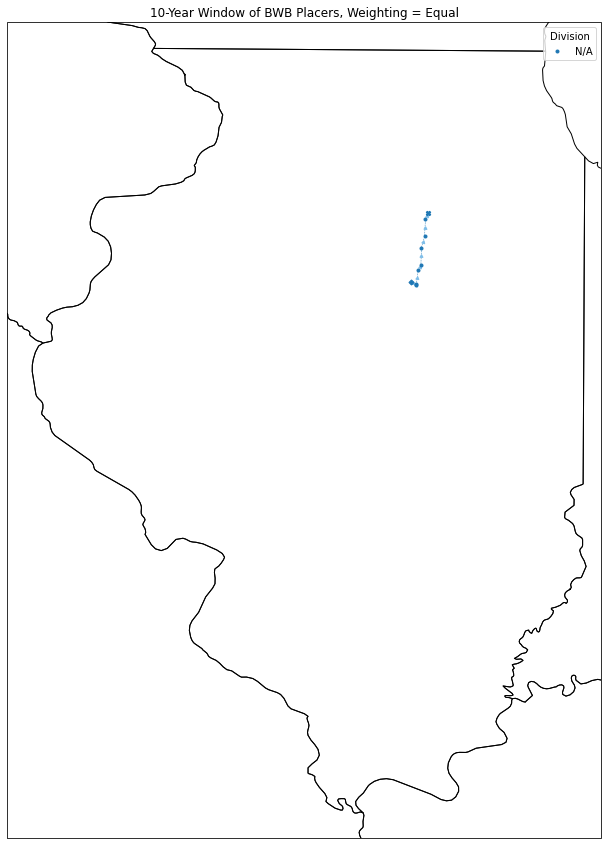

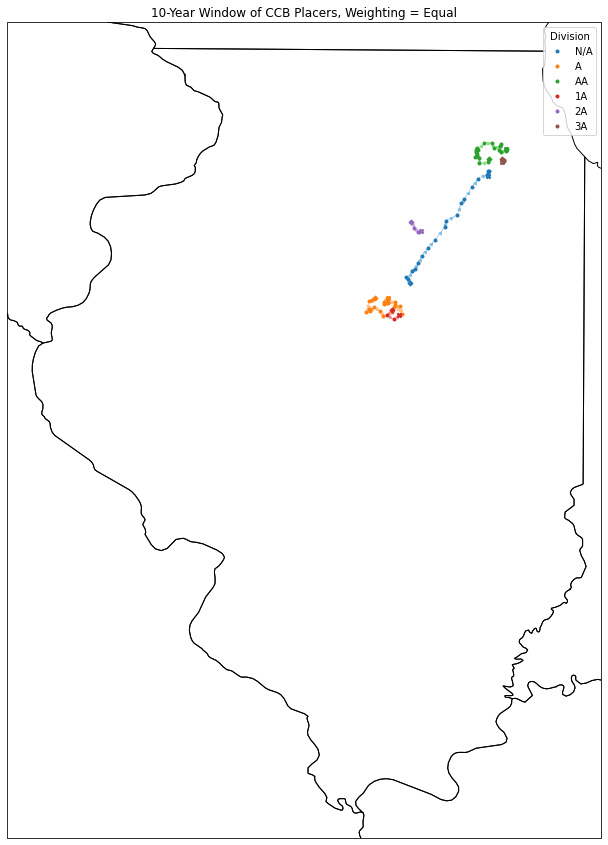

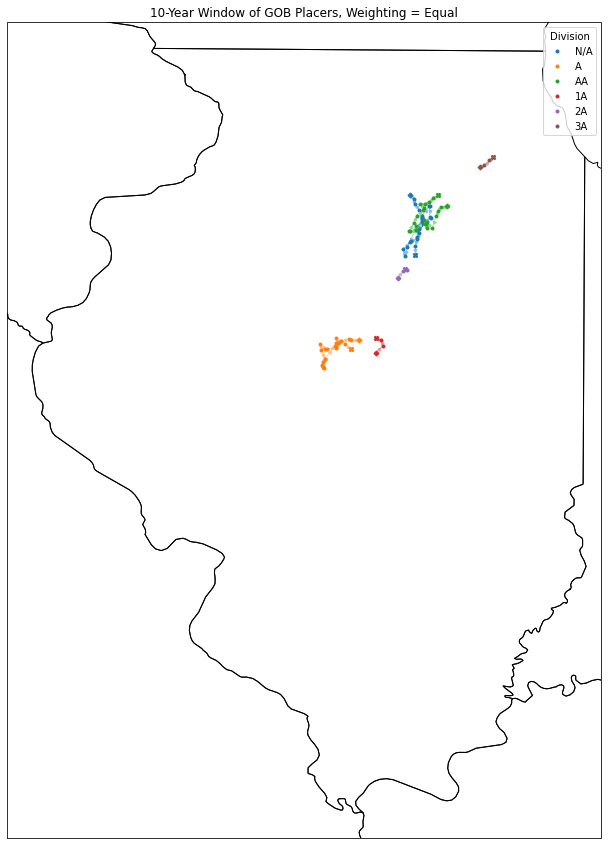

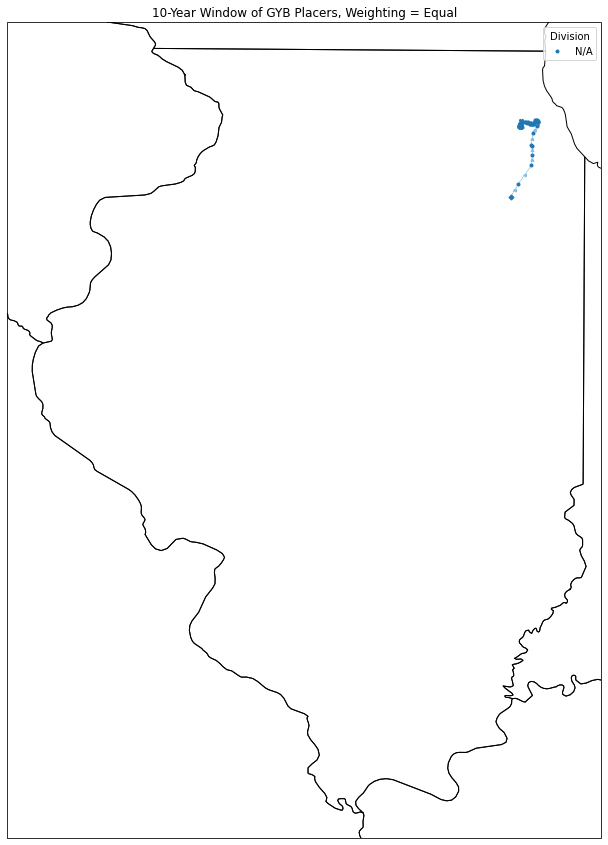

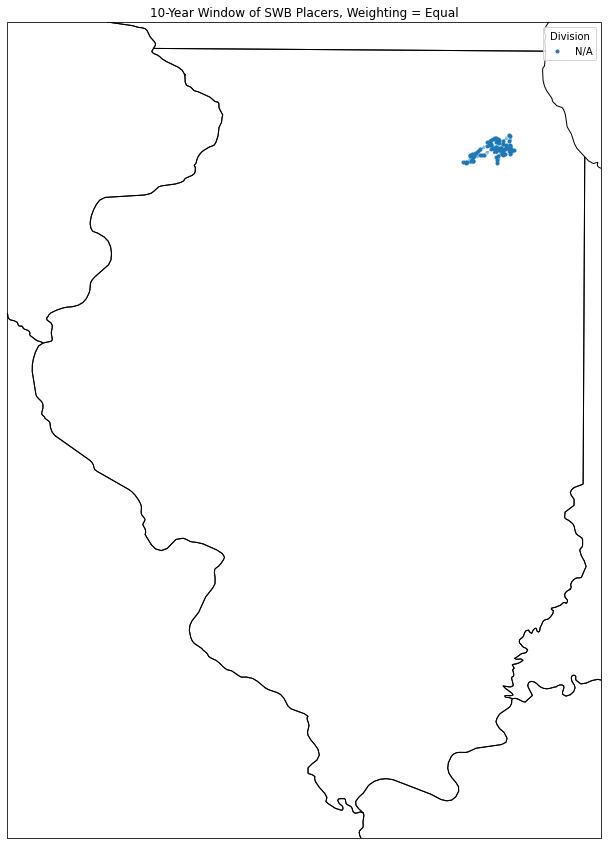

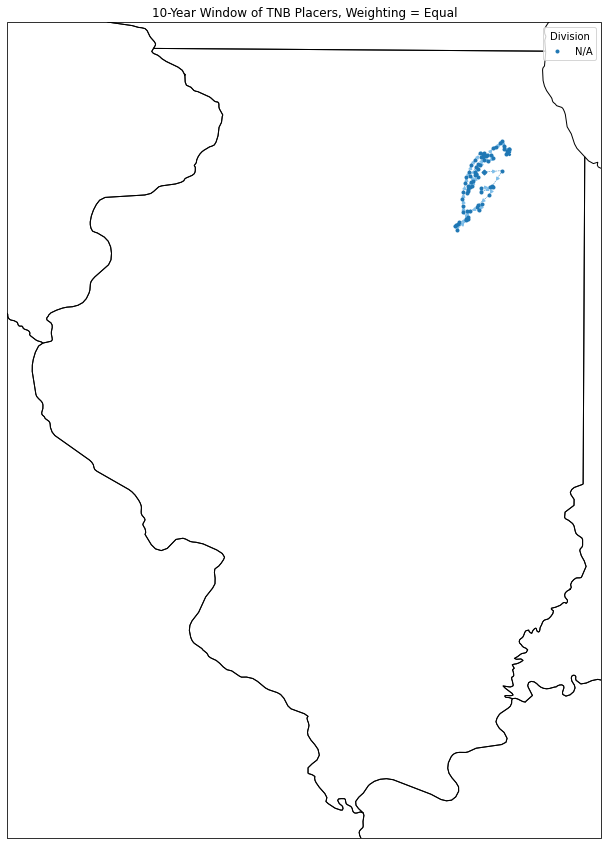

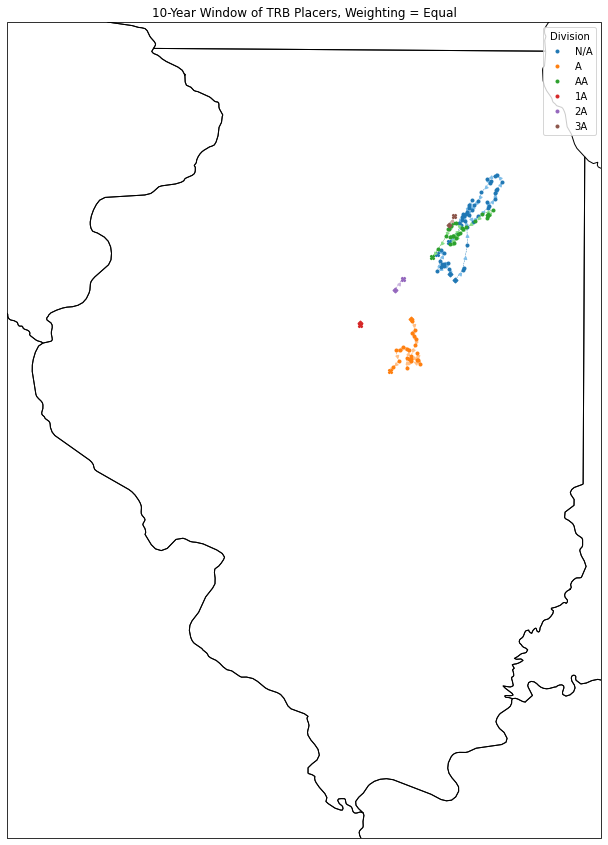

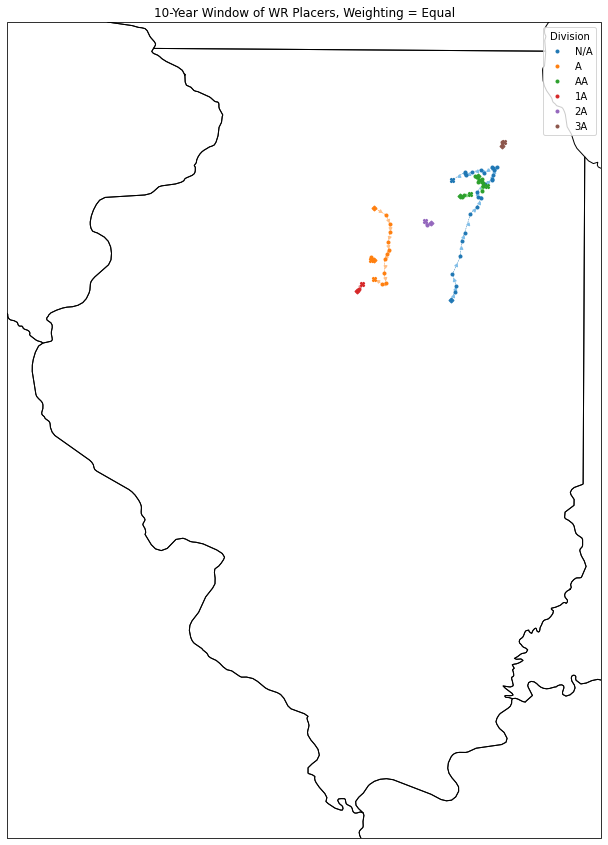

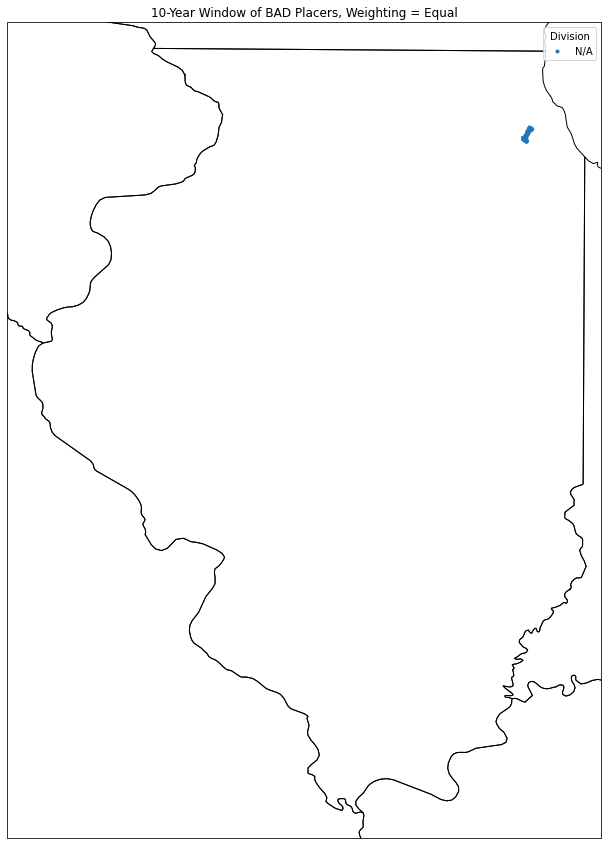

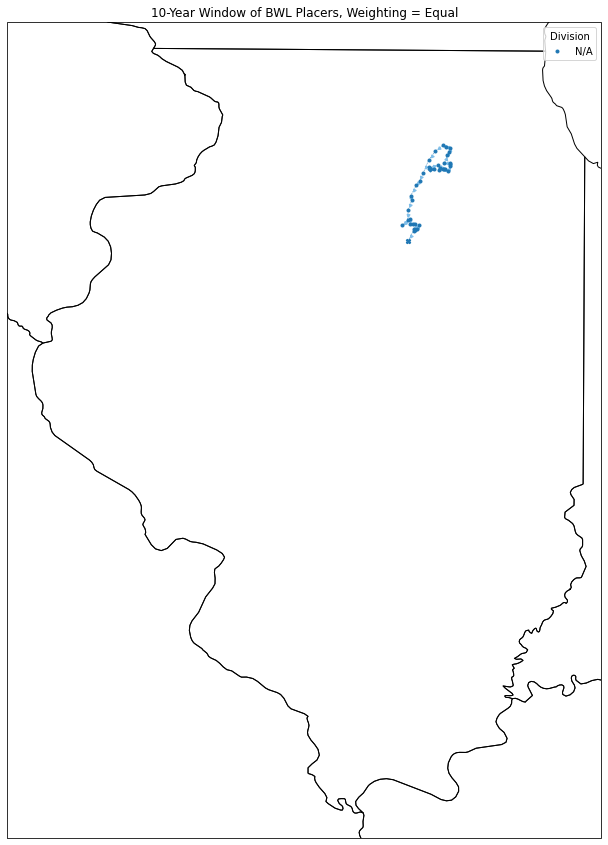

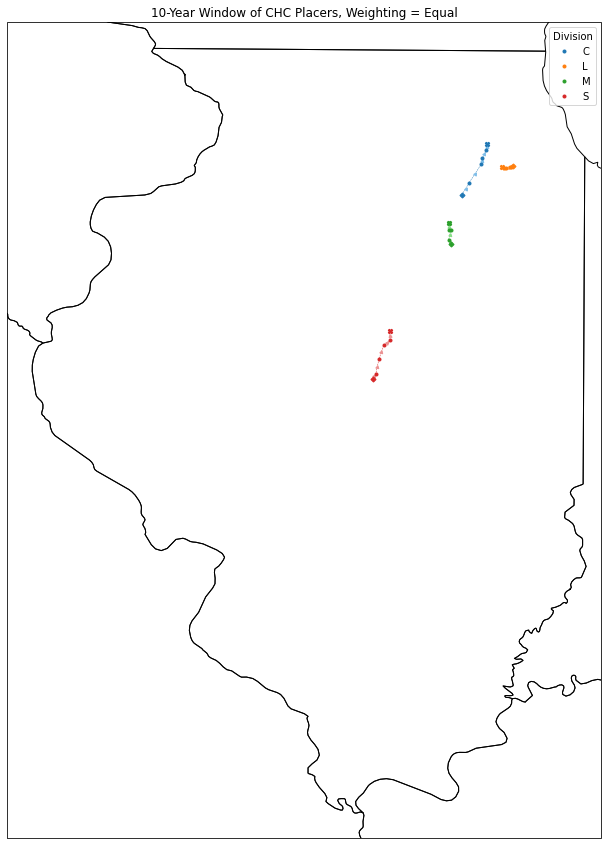

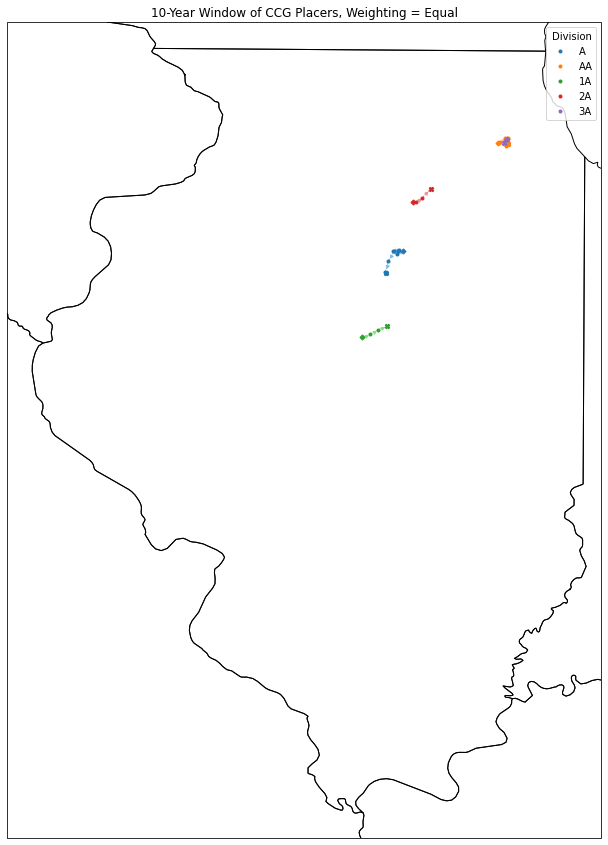

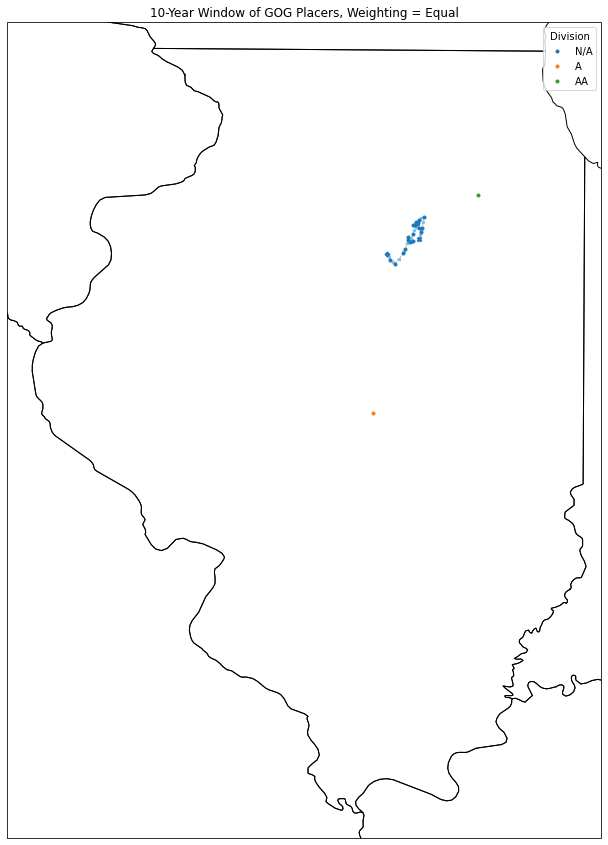

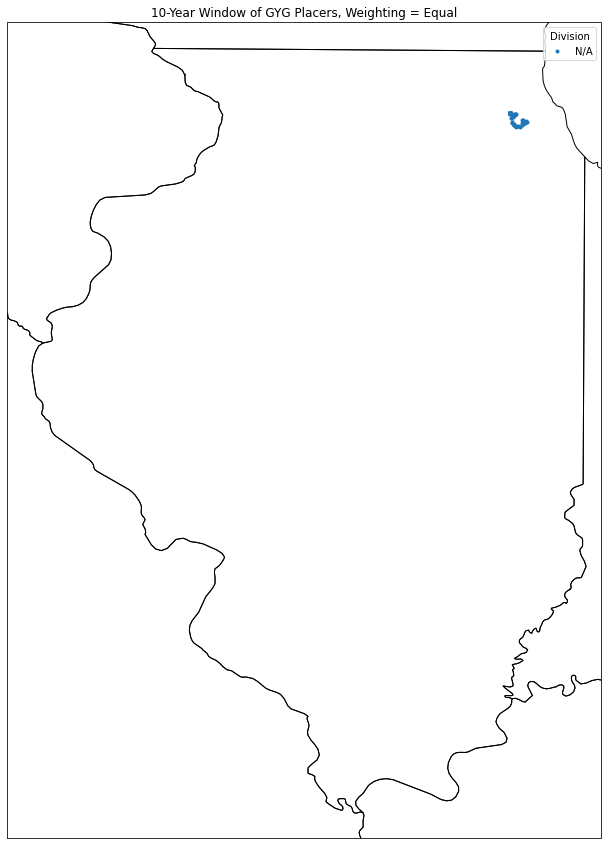

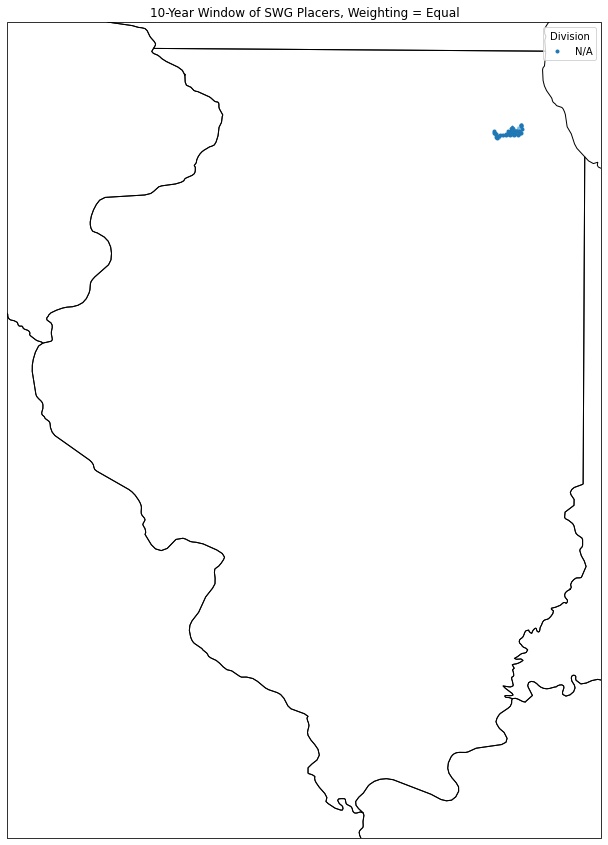

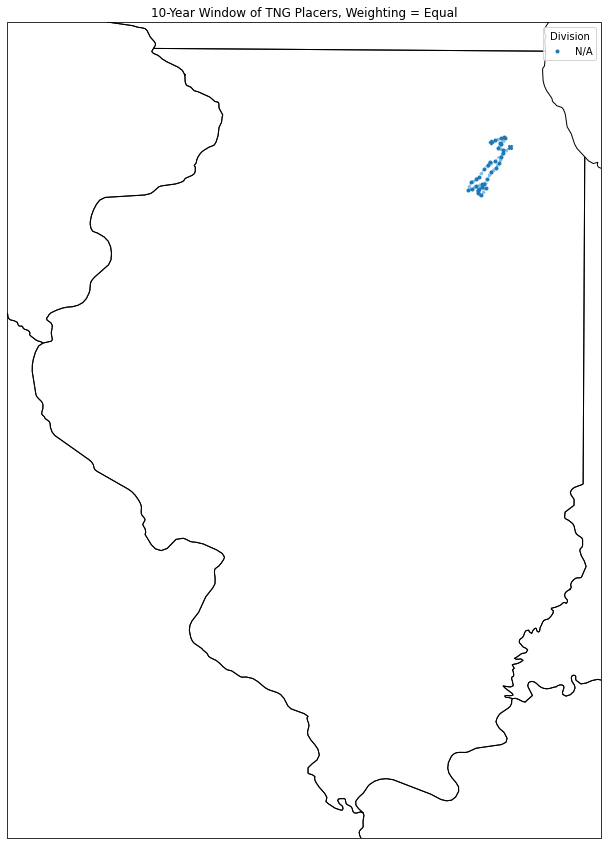

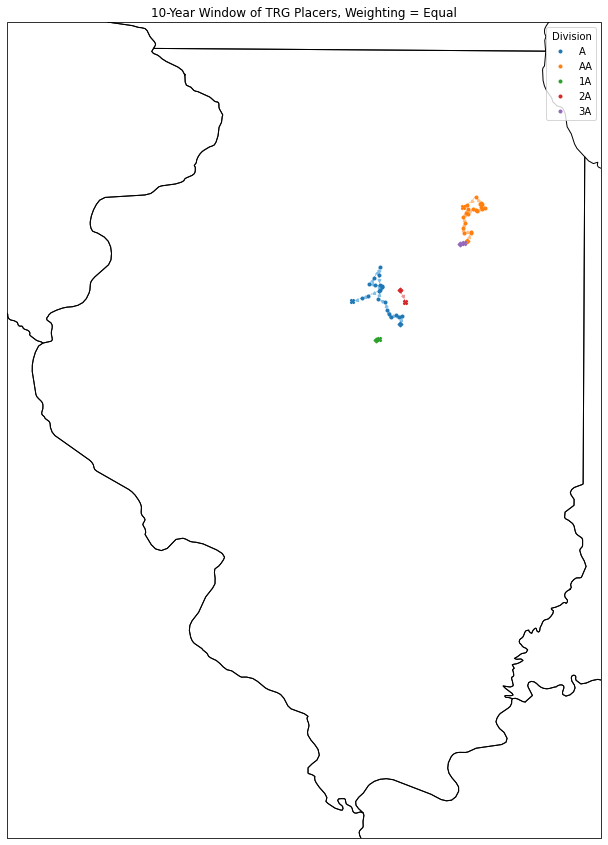

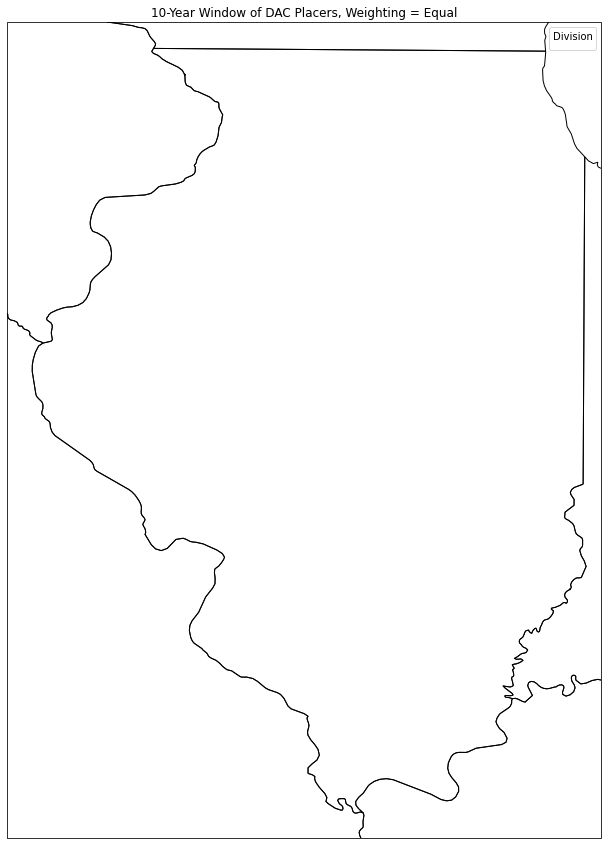

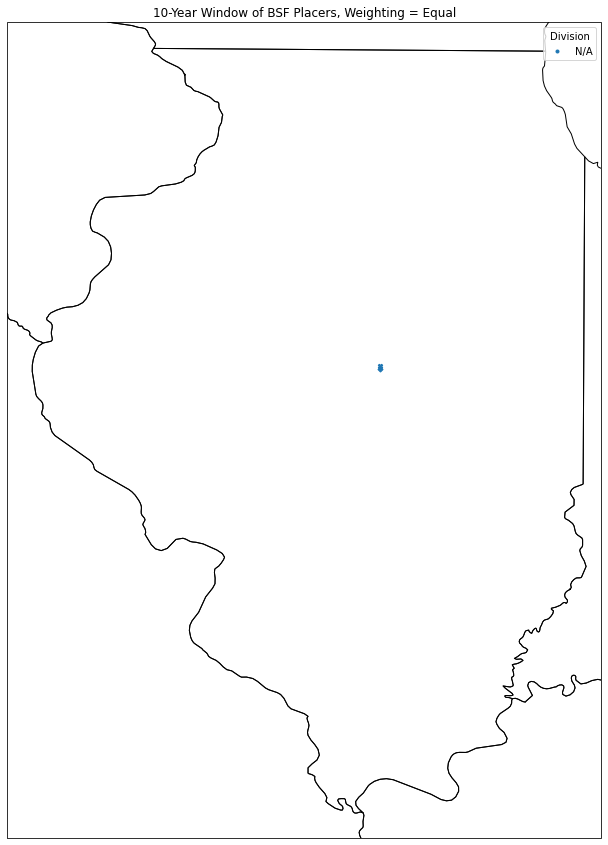

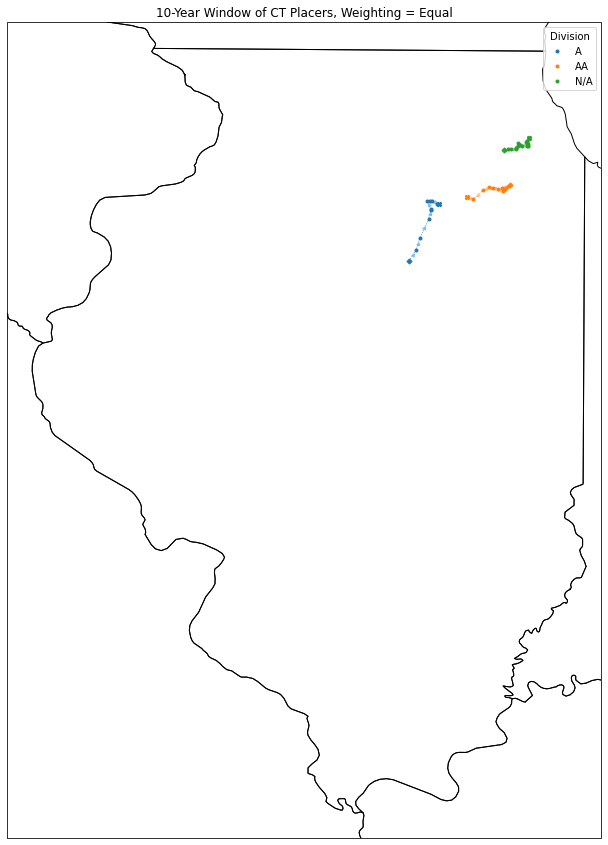

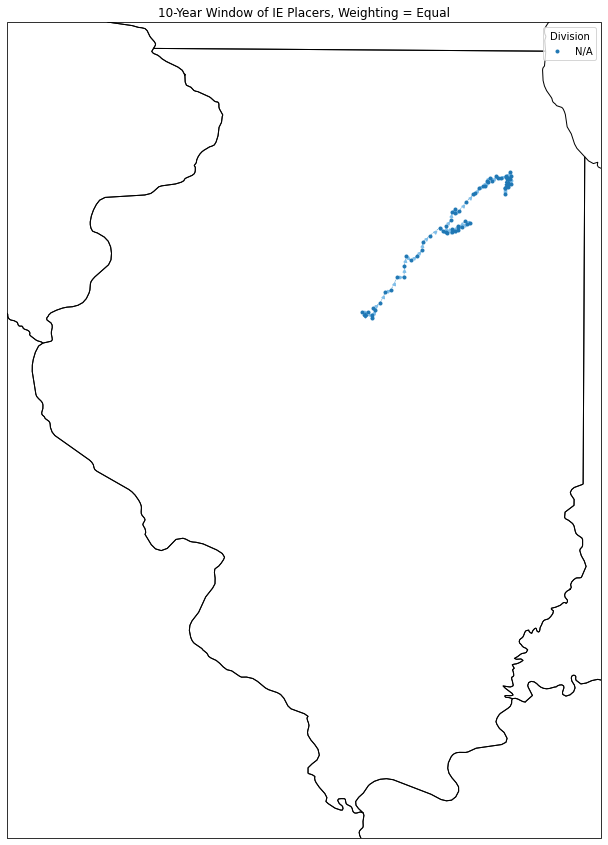

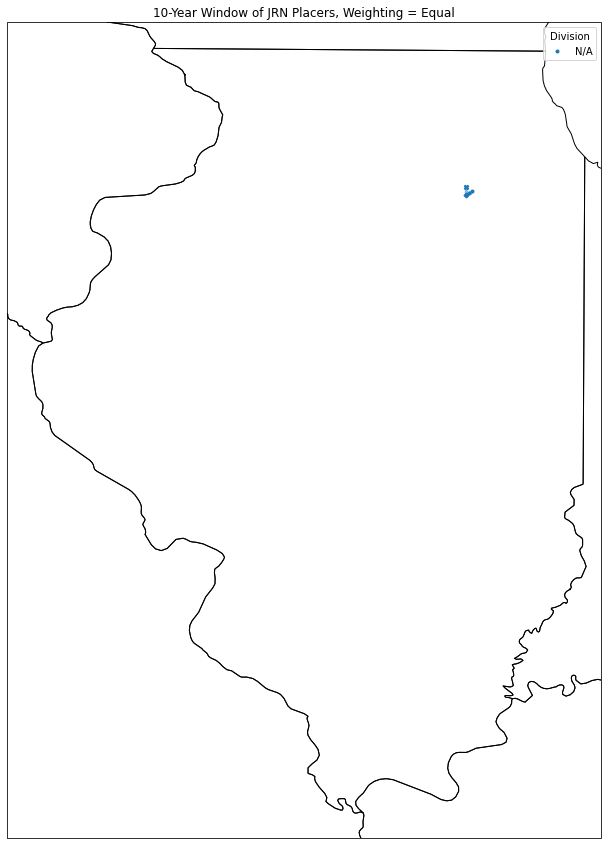

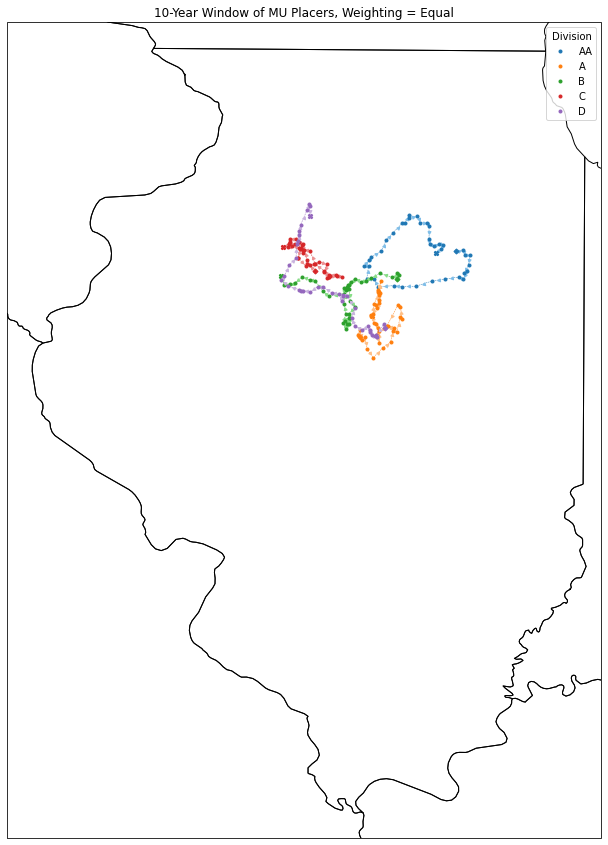

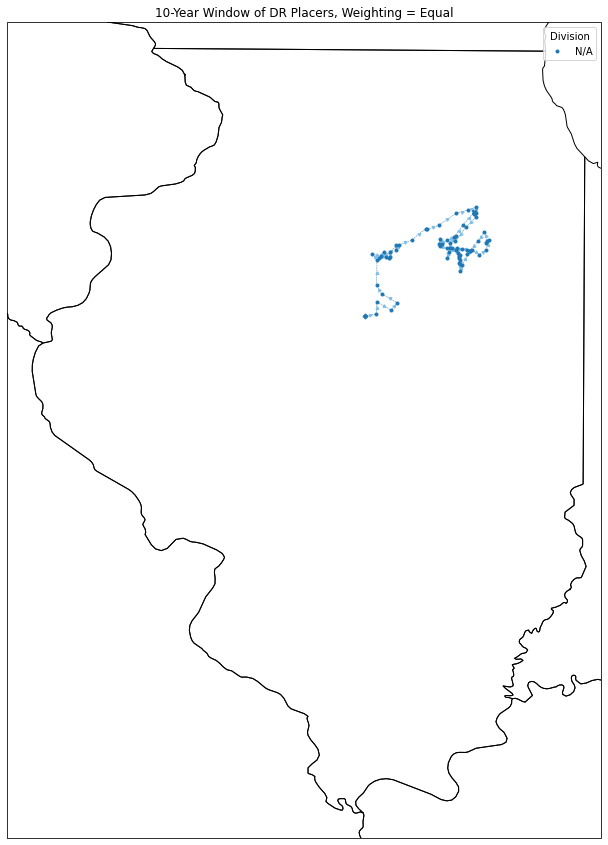

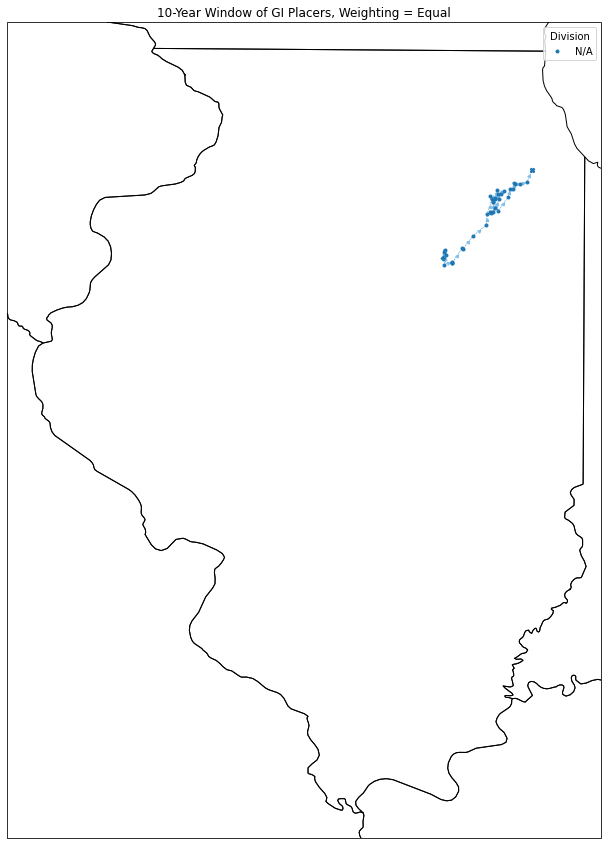

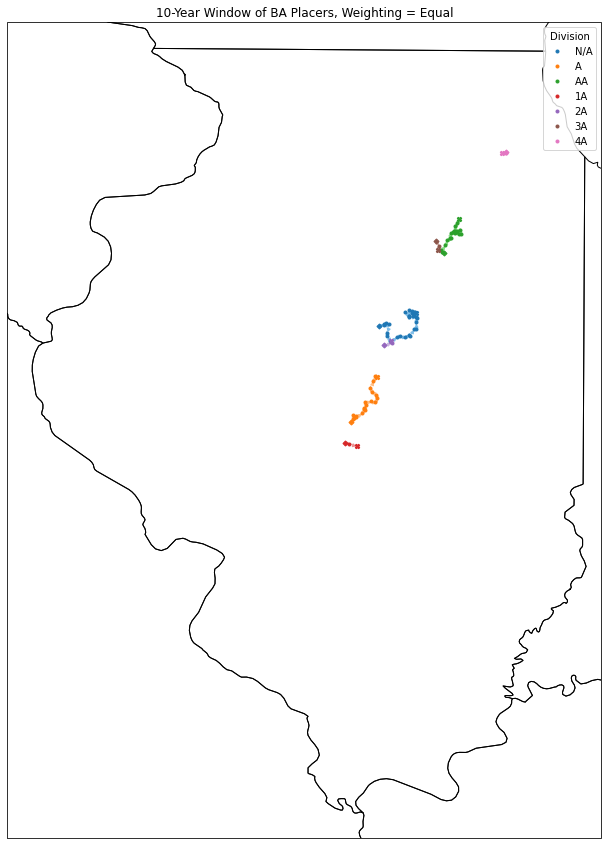

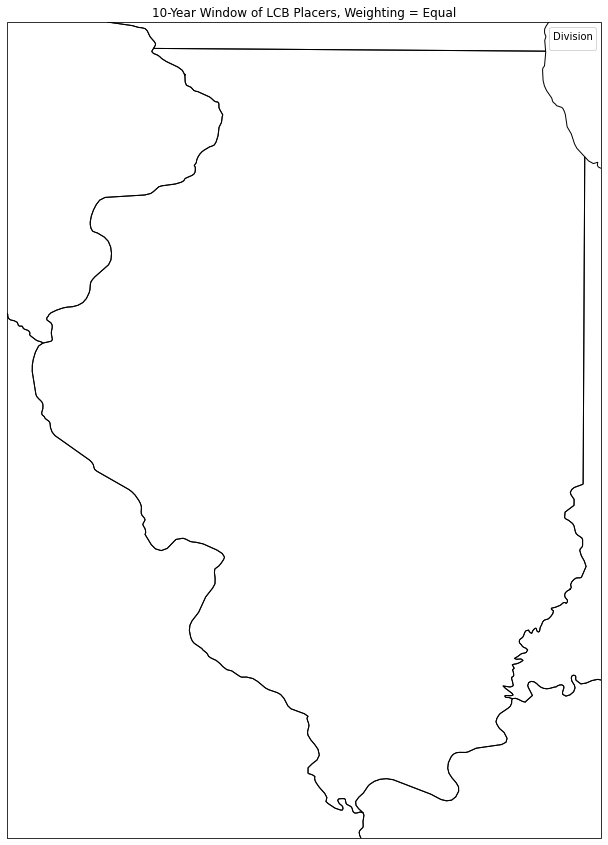

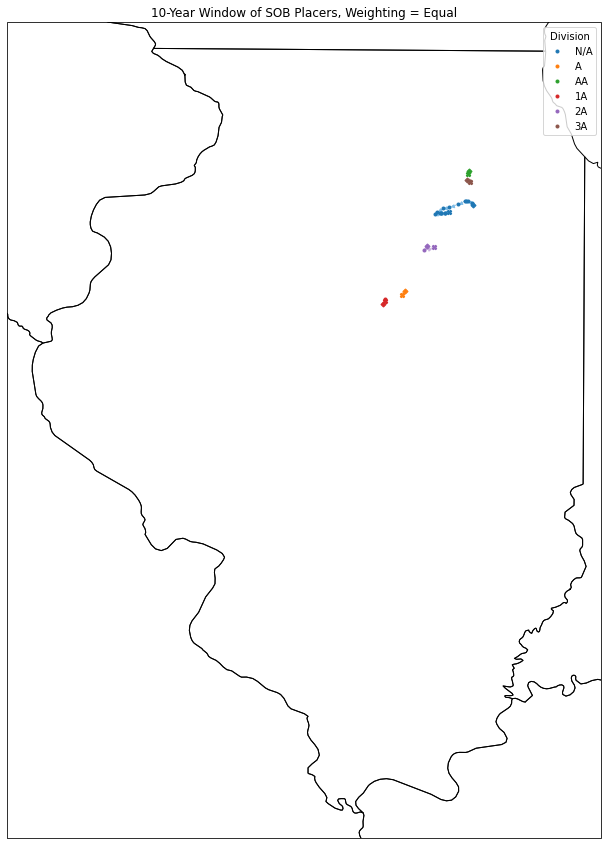

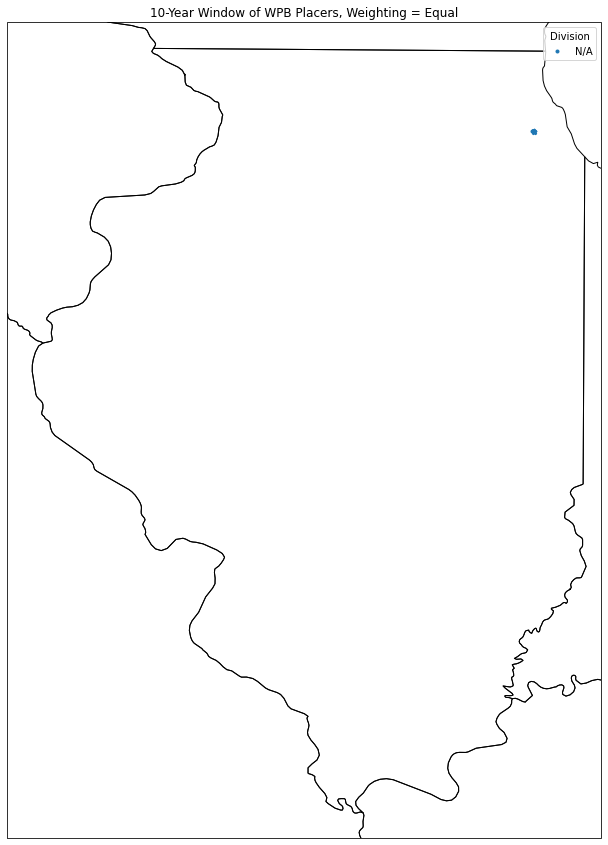

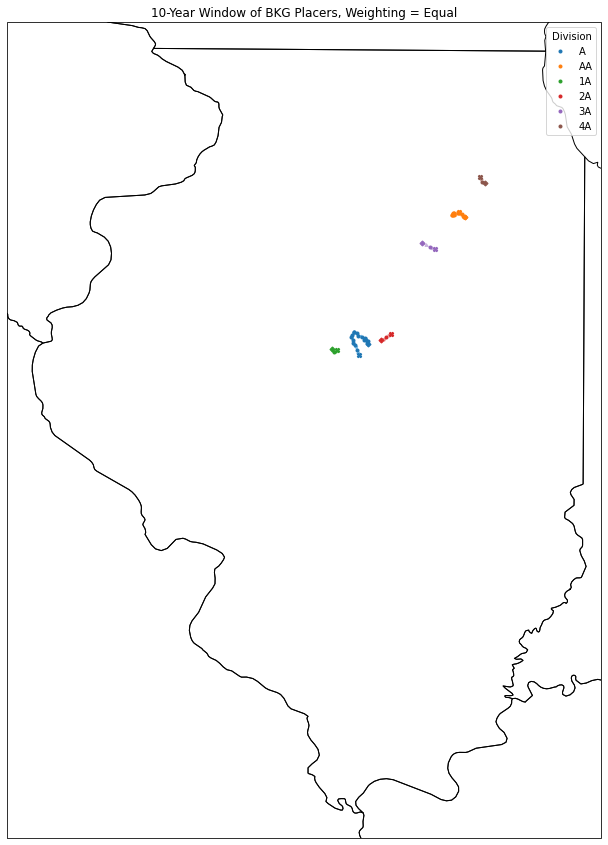

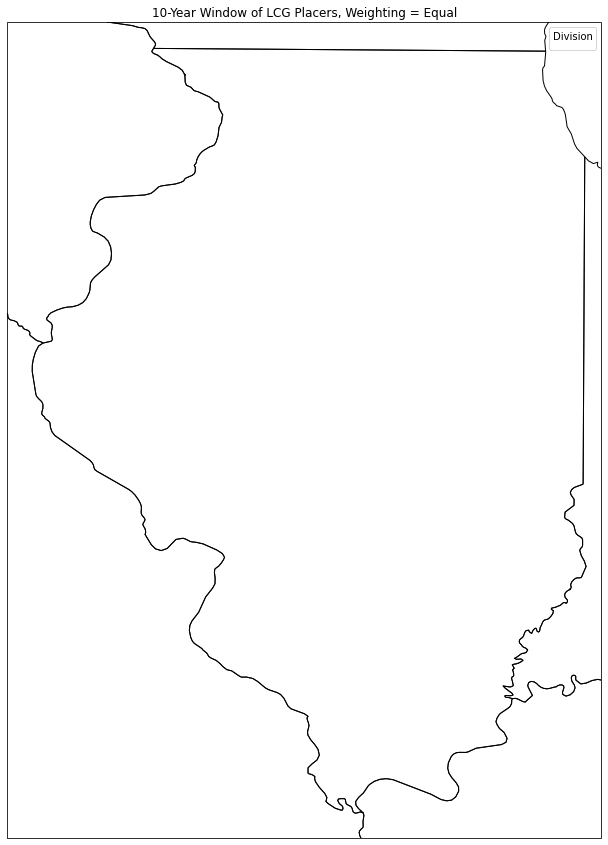

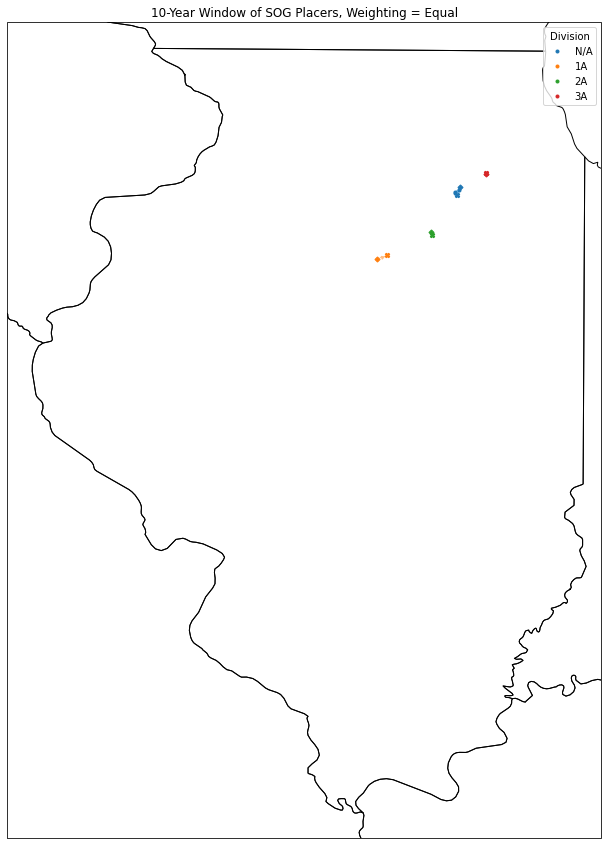

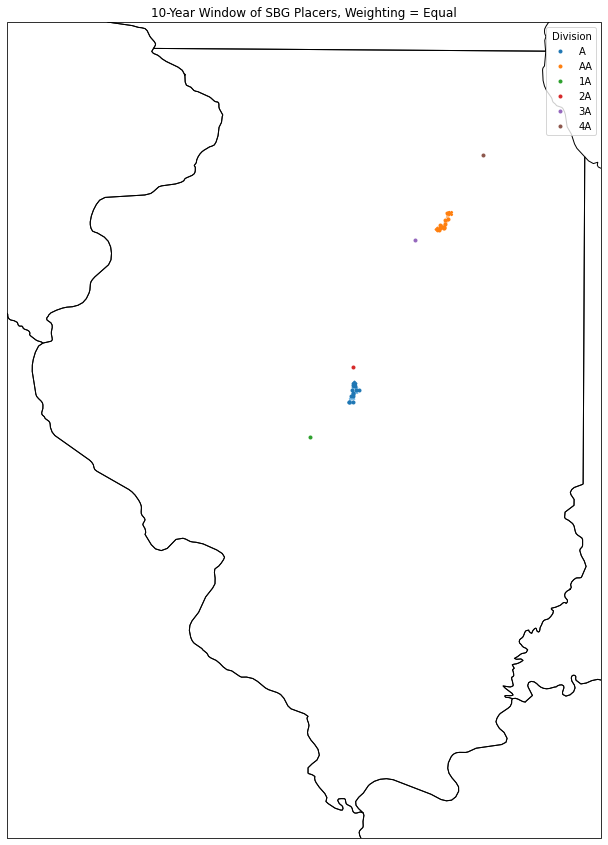

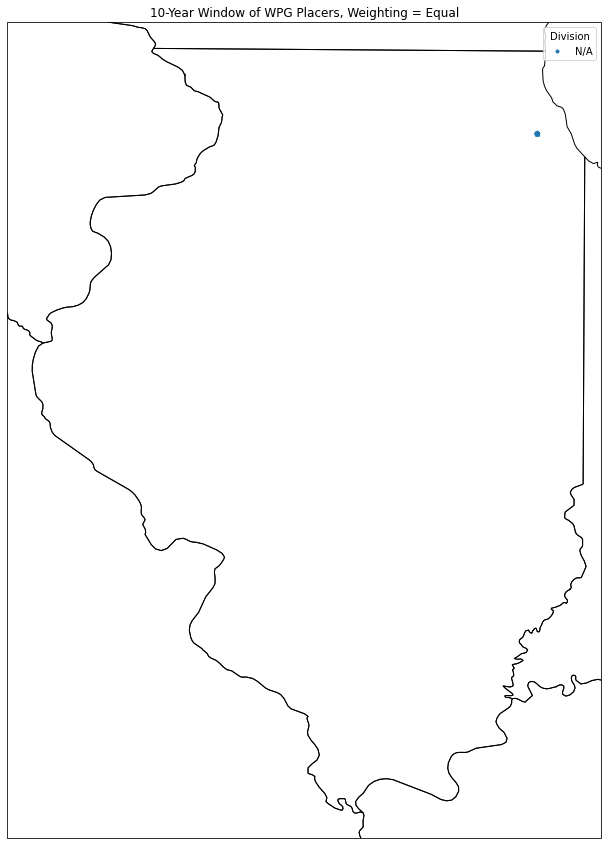

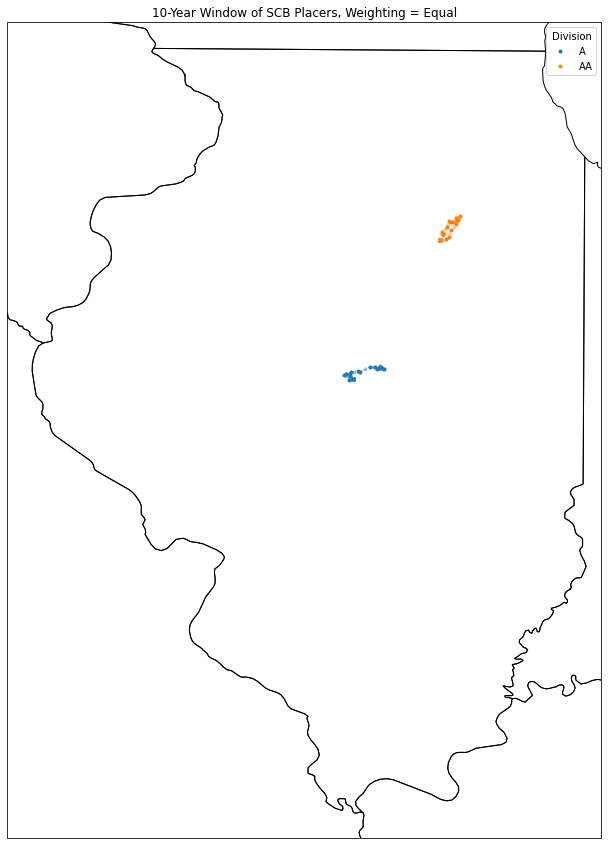

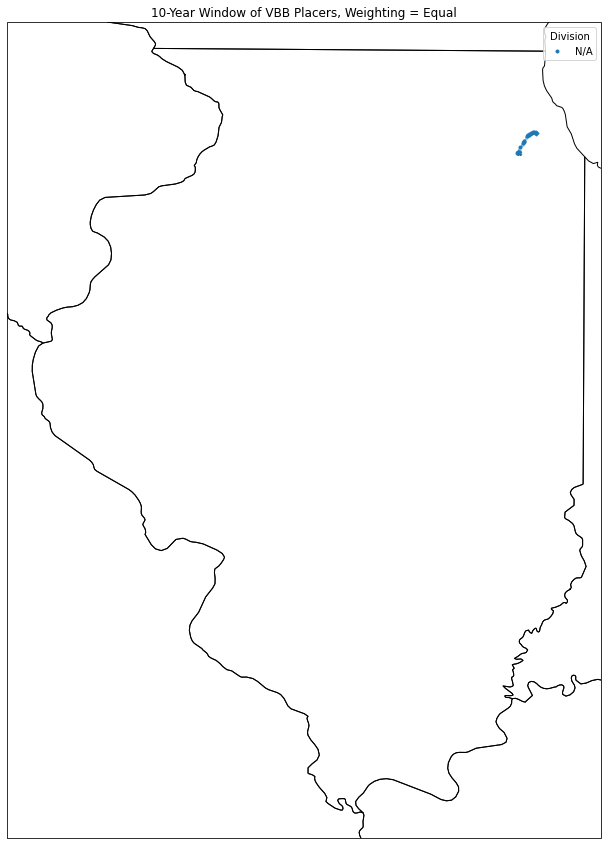

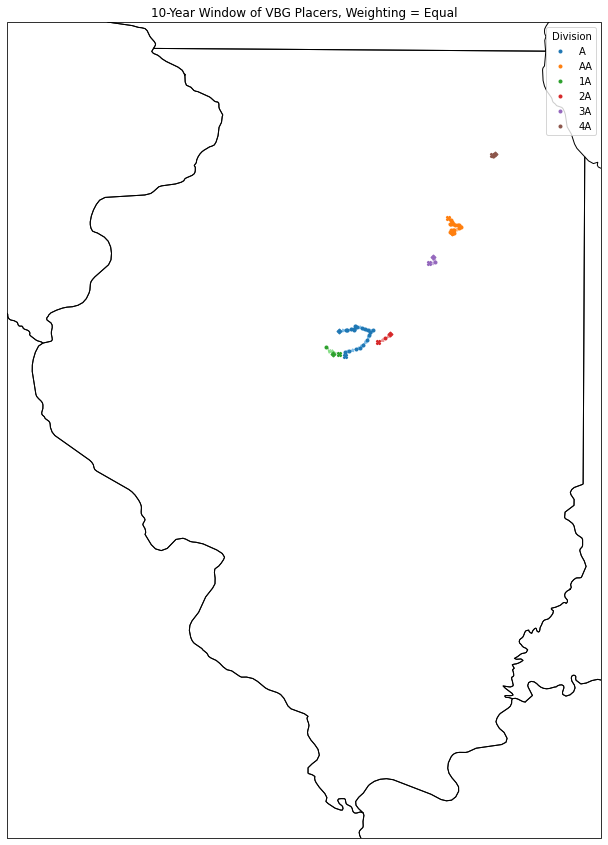

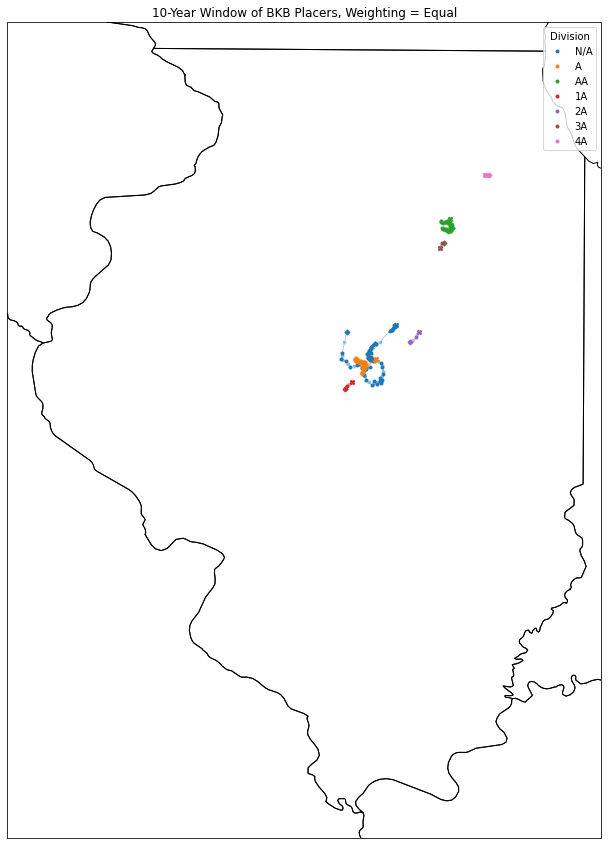

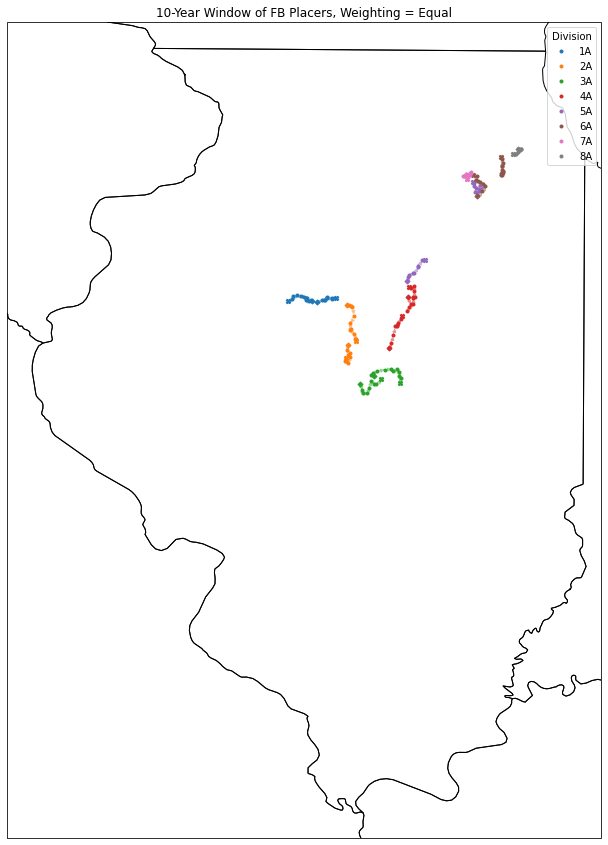

In [3]:
return_graphs(ihsa_tidy, connected =True, figsize = 15, window = 10, scale = 0.5)